# Introduction to ML - Unsupervised Clustering

**Unsupervised clustering** in machine learning are a group of algorithms used to group data points into clusters based on their inherent similarities *without predefined labels or categories*.

This method is useful in discovering natural patterns and structures within datasets

In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [2]:
# Mount GDrive's folders
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# This code imports a library "os" that allows file navigation
import os
# This code sets the home directory
# Find your folder and put the path here as a string
os.chdir('/content/drive/MyDrive/my_workspace')

## K-Means Clustering

### Read the dataset
The dataset we'll use is a table of grades of 100 students for 3 subjects.

In [4]:
df = pd.read_csv('Data/cc_rfm.csv')
df

,acct_num,recency,recency_score,frequency,frequency_score,total_amt,monetary_score,rfm_score,rfm_level
0,1.240000e+11,24,3,931,3,66457.92,3,9,Top
1,1.690000e+11,141,1,9,1,2814.60,1,3,Low
2,1.700000e+11,24,3,890,3,64448.85,3,9,Top
3,2.010000e+11,25,3,306,2,24489.46,2,7,Top
4,2.038000e+11,111,1,12,1,8803.87,1,3,Low
...,...,...,...,...,...,...,...,...,...
83,9.690000e+11,26,3,291,1,20507.08,1,5,Middle
84,9.710000e+11,25,3,907,3,61747.38,3,9,Top
85,9.890000e+11,25,3,301,1,19471.66,1,5,Middle
86,9.940000e+11,25,3,608,2,39818.18,2,7,Top


### Plot the dataset


We can use `df.hist()` to plot a histogram of each of the columns

array([[<Axes: title={'center': 'recency'}>,
        <Axes: title={'center': 'frequency'}>],
       [<Axes: title={'center': 'total_amt'}>, <Axes: >]], dtype=object)

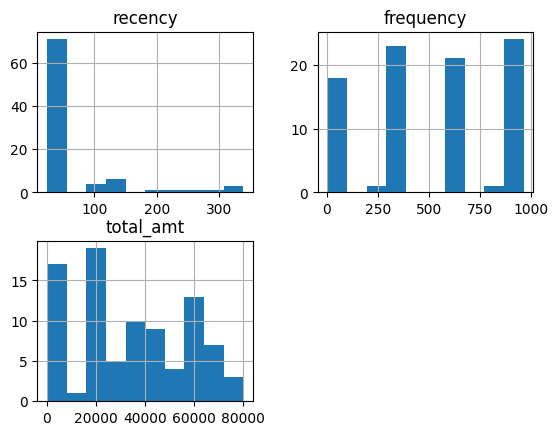

In [5]:
df[['recency','frequency','total_amt']].hist()

To visualize the distribution in 2D, we can plot any 2 columns at a time in a scatter plot using pandas `plot.

### Preprocessing the dataset

Before we proceed to clustering, we will check the following:
1. Does the data contain outliers?
2. Is the data standardized?

In [13]:
data = df[['recency','frequency','total_amt']].copy()


In [8]:
data.boxplot?


<Axes: >

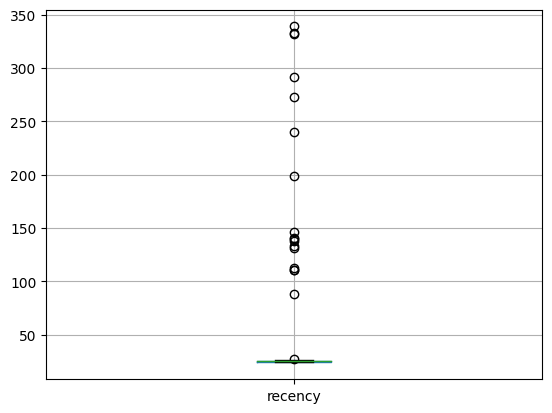

In [17]:
data[['recency']].boxplot()

#### Have you noticed an outlier?

While it is enticing to use an outlier detection (using Z-score or using interquartile range method), we must always treat an outlier for the WHOLE features with respect to the other data points.

We must also be VERY SURE about why a data point can be treated as an outlier since removing outliers can potentially degrade the quality of your data. Here's a story from NASA: https://robjhyndman.com/hyndsight/omitting-outliers/.




For now, let's skip removal of outliers and head straight to standardization.

In [43]:
# Call scaler and apply to the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# Convert data to pandas
scaled_data = pd.DataFrame(scaled_data, columns=data.columns)

In [44]:
# Show data after scaling
scaled_data

,recency,frequency,total_amt,labels
0,-0.433304,1.311588,1.392169,-1.394559
1,1.102957,-1.441478,-1.440491,-0.247632
2,-0.433304,1.189163,1.302748,-1.394559
3,-0.420174,-0.554644,-0.475778,0.899295
4,0.709044,-1.432520,-1.173918,-0.247632
...,...,...,...,...
83,-0.407044,-0.599434,-0.653028,0.899295
84,-0.420174,1.239925,1.182510,-1.394559
85,-0.420174,-0.569574,-0.699113,0.899295
86,-0.420174,0.347119,0.206478,0.899295


#### What happened?

We can see that each column is approximately of the same scale.

During scaling: for each column, we compute the mean and the standard deviation.

After, we convert each data point using the following transformation:

![](https://cdn-images-1.medium.com/v2/resize:fit:370/1*Nlgc_wq2b-VfdawWX9MLWA.png)

where z is the transformed value, x is the unscaled value, μ "miu" is the mean for the specific column where the data belongs and σ "sigma" is the standard deviation.

### Applying K-Means clustering

Now, let's apply K-Means!

In [45]:
# Initialize clustering
kmeans = KMeans(
    init="random",
    n_clusters=3,
    n_init=10,
    max_iter=300,
    random_state=42
    )

In [21]:
# Apply clustering to the data
kmeans.fit(scaled_data)

KMeans(init='random', n_clusters=3, n_init=10, random_state=42)

In [22]:
# Display the inertia (the lower, the better)
kmeans.inertia_

46.545056603826026

In [23]:
# Display location of centroids
kmeans.cluster_centers_

array([[-0.42673922,  1.23693868,  1.27397498],
       [ 1.76951955, -1.44305853, -1.33743085],
       [-0.42192472, -0.16952024, -0.23082278]])

To test different cluster numbers, let's create a function for clustering for modularity.

In [52]:
def run_kmeans(k, scaled_data):
  kmeans = KMeans(
        #init="random",
        n_clusters=k,
        #n_init=10,
       # max_iter=300,
        random_state=42
        )
  kmeans.fit(scaled_data)
  return kmeans.inertia_,kmeans.labels_

In [53]:
# Create function to run clustering across a range
def optimize_kmeans(cluster_range=None, scaled_data=None):
  # Initialize clustering
  inertias = []
  labels = []
  silhouette_values = []
  for n_clusters in cluster_range:
    inertia, label_vals = run_kmeans(n_clusters, scaled_data)

    # Print inertia
    print(f"n_clusters = {n_clusters}: inertia = {inertia:.2f}")
    inertias.append(inertia)
    labels.append(label_vals)

    # Compute silhouette score
    silhouette = silhouette_score(scaled_data, label_vals)
    silhouette_values.append(silhouette)

  return inertias, labels, silhouette_values

In [55]:
# Test clustering for clusters 2-10
clusters = range(2,11)
inertia_values, labels, silhouette_values = optimize_kmeans(
    cluster_range = clusters,
    scaled_data=scaled_data
)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will chang

n_clusters = 2: inertia = 157.15
n_clusters = 3: inertia = 46.55
n_clusters = 4: inertia = 27.00
n_clusters = 5: inertia = 8.31
n_clusters = 6: inertia = 6.79
n_clusters = 7: inertia = 5.28
n_clusters = 8: inertia = 3.90
n_clusters = 9: inertia = 3.14
n_clusters = 10: inertia = 2.60


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



### Determine best k value

The **inertia** or within-cluster sum of squares (wcss) in clustering is defined as follows: inertia quantifies the compactness (or cohesiveness) of the clusters. The smaller inertia we have within clusters, the more homogeneous (similar) the data points are within the same cluster

**Lower inertia implies better clustering**.

#### Elbow method
Let's identify the optimal number of clusters using the elbow method.

Text(0, 0.5, 'Inertia')

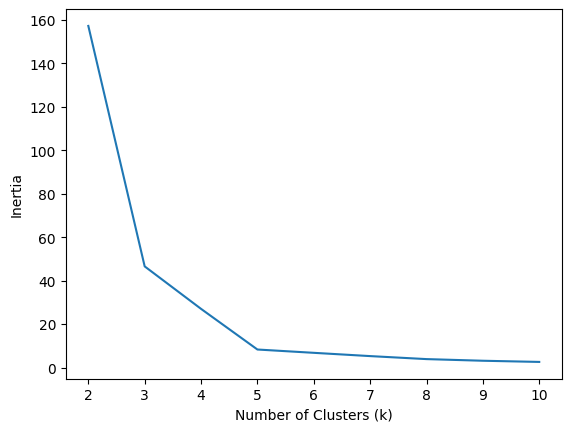

In [56]:
plt.plot(clusters, inertia_values)
plt.xticks(clusters)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")

To find the elbow, you may (1) visually inspect the curve, or (2) compute for the rate of change of slope (aka the 2nd derivative) and use the minimum value to detect where the curve changes the fastest.

In [57]:
# Calculate the first derivative of the inertias
differences = np.diff(inertia_values)

# Calculate the second derivative
second_derivative = np.diff(differences)

# Find the index of the maximum value of the second derivative
# + 1 because index starts at 0 when we did the first derivative
elbow_index = np.argmax(second_derivative) + 1

print(f"The best elbow value (optimal number of clusters) is {clusters[elbow_index]}")

The best elbow value (optimal number of clusters) is 3


#### Silhouette method

We can confirm the optimal cluster detected by the elbow method using the silhouette values score.

Unlike the elbow method, where you're looking for a point where the rate of decrease in inertia slows down, with silhouette score, you're looking for a point where the **silhouette score is maximized**.


Text(0, 0.5, 'Silhouette')

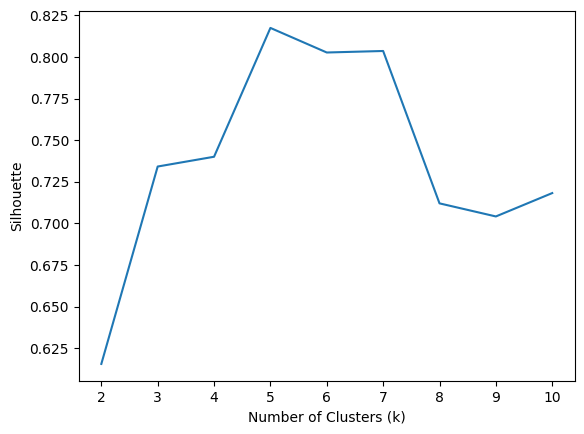

In [58]:
plt.plot(clusters, silhouette_values)
plt.xticks(clusters)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette")

### Profiling your clusters

It seems that elbow occurs at 3, which checks out! Now, what's next?

**The most important part of clustering is in profiling: what makes one cluster different from the other?**

This is important since in a lot of decisions like in business (e.g. marketing strategies for customer profiling) will be informed by the profile of our clusters.

In marketing strat, it asks the questions:
* What makes the profile of my customers different?
* Who should I target in my ads?
* Who will deliver us more sales?

In [30]:
# Apply optimal k = 3
inertia, labels = run_kmeans(
    k=3,
    scaled_data=scaled_data
)

What's the labels?

This is the cluster of our data points ranging from 0 to n_clusters-1.

Note that in itself, <b>these cluster labels will not make sense </b>. We will be the one to interpret these labels later on.

In [31]:
# Show labels
labels

array([0, 1, 0, 2, 1, 0, 2, 0, 1, 2, 1, 2, 2, 2, 1, 1, 0, 2, 2, 2, 2, 1,
       2, 1, 2, 1, 2, 0, 0, 2, 2, 0, 0, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2,
       2, 2, 0, 0, 1, 1, 0, 1, 2, 1, 2, 2, 2, 2, 2, 0, 2, 2, 1, 2, 2, 0,
       0, 2, 0, 0, 0, 0, 2, 0, 0, 1, 1, 2, 2, 2, 2, 1, 0, 2, 0, 2, 2, 0],
      dtype=int32)

In [32]:
# Append labels to original data and scaled data
data['labels'] = labels
scaled_data['labels'] = labels

In [33]:
# Show data
data

,recency,frequency,total_amt,labels
0,24,931,66457.92,0
1,141,9,2814.60,1
2,24,890,64448.85,0
3,25,306,24489.46,2
4,111,12,8803.87,1
...,...,...,...,...
83,26,291,20507.08,2
84,25,907,61747.38,0
85,25,301,19471.66,2
86,25,608,39818.18,2


In [34]:
# Show scaled data
scaled_data

,recency,frequency,total_amt,labels
0,-0.433304,1.311588,1.392169,0
1,1.102957,-1.441478,-1.440491,1
2,-0.433304,1.189163,1.302748,0
3,-0.420174,-0.554644,-0.475778,2
4,0.709044,-1.432520,-1.173918,1
...,...,...,...,...
83,-0.407044,-0.599434,-0.653028,2
84,-0.420174,1.239925,1.182510,0
85,-0.420174,-0.569574,-0.699113,2
86,-0.420174,0.347119,0.206478,2


In profiling, we usually get the average of each feature per cluster. This way, we can compare the profile of one cluster to the other based on the average of the features.

In [35]:
# Apply groupings in the ORIGINAL dataset
data.groupby('labels').mean()

,recency,frequency,total_amt
labels,,,
0,24.500000,906.000000,63802.383077
1,191.764706,8.470588,5130.120000
2,24.866667,434.977778,29993.049778


Based on this, we can already spot the differences across clusters 0, 1, 2 and 3 based on the average of each of the feature columns.

Now, let's go back to the scaled data. We will use them to build radar charts.

In [36]:
# Apply groupings in the SCALED dataset
scaled_data.groupby('labels').mean()

,recency,frequency,total_amt
labels,,,
0,-0.426739,1.236939,1.273975
1,1.769520,-1.443059,-1.337431
2,-0.421925,-0.169520,-0.230823


In [37]:
# Apply groupings in the dataset then transpose and save
grouped_data = scaled_data.groupby('labels').mean().T

In [38]:
# Show the data
grouped_data

labels,0,1,2
recency,-0.426739,1.769520,-0.421925
frequency,1.236939,-1.443059,-0.169520
total_amt,1.273975,-1.337431,-0.230823


In [39]:
# Show the transformed scaled data
grouped_data

labels,0,1,2
recency,-0.426739,1.769520,-0.421925
frequency,1.236939,-1.443059,-0.169520
total_amt,1.273975,-1.337431,-0.230823


In [40]:
# Plot radar chart per cluster
for i in grouped_data.columns:
  # Filter cluster
  cluster = grouped_data[i]

  # Create radar chart
  fig = px.line_polar(
      cluster,
      r=cluster.values,
      theta=cluster.index,
      line_close=True,
      title=f"Cluster {i}"
      )
  fig.update_traces(fill='toself')

  # Show figure
  fig.show()

## Taking it further

1. Remove outliers (when necessary). You can use basic methods like removing percentiles on extreme ends of the distributio(["windsorization"](https://en.wikipedia.org/wiki/Winsorizing)) or [IQR filtering](https://www.khanacademy.org/math/statistics-probability/summarizing-quantitative-data/box-whisker-plots/a/identifying-outliers-iqr-rule)

2. Explore other k-means variants : [k-medians](https://pyclustering.github.io/docs/0.9.3/html/df/d68/classpyclustering_1_1cluster_1_1kmedians_1_1kmedians.html) for additional robustness, and [k-modes](https://harikabonthu96.medium.com/kmodes-clustering-2286a9bfdcfb) for categorical data

In [ ]:
data["rfm_level"] = df["rfm_level"]

In [ ]:
data.sort_values("rfm_level", ascending=False)


,recency,frequency,total_amt,labels,rfm_level
0,24,931,66457.92,0,Top
47,25,921,59061.36,0,Top
59,25,903,78515.67,0,Top
58,24,329,25566.60,2,Top
57,24,321,30725.34,2,Top
...,...,...,...,...,...
75,140,7,4308.91,1,Low
62,199,8,5573.74,1,Low
23,292,7,4621.94,1,Low
51,138,9,6288.74,1,Low
